In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import itk
import glob
import numpy as np
import matplotlib.pyplot as plt
import icon_registration as icon
import icon_registration.networks as networks
import torch
import random

In [4]:
roots = glob.glob("dxa2d_processed/dxa2d/*")

paths = [sorted(glob.glob(f"{root}/*.dcm")) for root in roots]

In [5]:
knees = []
for path in paths:
    for subpath in path:
        im = np.array(itk.imread(subpath))[0]
        if im.shape[1] == 640:
            knees.append(im)


In [6]:
flipped_knees = []

for im in knees[:84:2]:
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()
    
for im in knees[85::2]:
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()

for im in knees[1:85:2]:
    im = np.flip(im, axis=1)
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()

for im in knees[86::2]:
    im = np.flip(im, axis=1)
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()
    


In [7]:
big_enough_knees = []
for im in flipped_knees:
    if im.shape[0] >= 845:
        big_enough_knees.append(im[:845])
big_enough_knees = torch.tensor(np.array(big_enough_knees))[:, None, :, :] / 255.

test_imgs = big_enough_knees[-10:]
big_enough_knees = big_enough_knees[:-10]

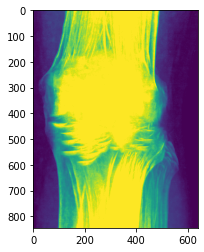

In [8]:
plt.imshow(torch.max(big_enough_knees, axis=0)[0][0])

In [9]:

BATCH_SIZE = 4
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
for _ in range(3):
    inner_net = icon.TwoStepRegistration(icon.DownsampleRegistration(inner_net, 2), icon.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

netGrad = icon.GradientICON(
    inner_net,
    icon.LNCC(sigma=5),
    3
)
input_shape = big_enough_knees[:1].size()
netGrad.assign_identity_map(input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.001)
netGrad.train()
0

0

In [12]:
def make_batch():
    idx = range(len(big_enough_knees))
    imgs_idx = [random.choice(idx) for _ in range(BATCH_SIZE)]

    imgs = [big_enough_knees[i:i+1] for i in imgs_idx]
    return torch.cat(imgs).cuda()
    

In [13]:
make_batch().shape

torch.Size([4, 1, 845, 640])

In [11]:
netGrad(make_batch(), make_batch())

ICONLoss(all_loss=tensor(1.9139, device='cuda:0', grad_fn=<AddBackward0>), inverse_consistency_loss=tensor(0., device='cuda:0', grad_fn=<AddBackward0>), similarity_loss=tensor(1.9139, device='cuda:0', grad_fn=<AddBackward0>), transform_magnitude=tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), flips=tensor(0.))

In [87]:
icon.train_batchfunction(netGrad, optimizerGrad, lambda : (make_batch(), make_batch()), steps=2000)

ICONLoss(all_loss=0.04788707569241524, inverse_consistency_loss=0.012414593249559402, similarity_loss=0.01064329594373703, transform_magnitude=0.0021371962502598763, flips=0.0)
ICONLoss(all_loss=0.04399140179157257, inverse_consistency_loss=0.010724086314439774, similarity_loss=0.01181914284825325, transform_magnitude=0.002786071738228202, flips=0.0)
ICONLoss(all_loss=0.047577641904354095, inverse_consistency_loss=0.012033889070153236, similarity_loss=0.011475970968604088, transform_magnitude=0.002056935103610158, flips=0.0)
ICONLoss(all_loss=0.053430818021297455, inverse_consistency_loss=0.012058250606060028, similarity_loss=0.01725606434047222, transform_magnitude=0.0018191937124356627, flips=0.0)
ICONLoss(all_loss=0.042245082557201385, inverse_consistency_loss=0.010066011920571327, similarity_loss=0.012047046795487404, transform_magnitude=0.0024665570817887783, flips=0.0)
ICONLoss(all_loss=0.051673758774995804, inverse_consistency_loss=0.011587679386138916, similarity_loss=0.0169107

ICONLoss(all_loss=0.023792613297700882, inverse_consistency_loss=0.0031231828033924103, similarity_loss=0.014423064887523651, transform_magnitude=0.0018940215231850743, flips=0.0)
ICONLoss(all_loss=0.024977542459964752, inverse_consistency_loss=0.0035170791670680046, similarity_loss=0.014426304027438164, transform_magnitude=0.0038734672125428915, flips=0.0)
ICONLoss(all_loss=0.02443603239953518, inverse_consistency_loss=0.0033872858621180058, similarity_loss=0.014274174347519875, transform_magnitude=0.003509493311867118, flips=0.0)
ICONLoss(all_loss=0.021777108311653137, inverse_consistency_loss=0.0027624471113085747, similarity_loss=0.013489766046404839, transform_magnitude=0.0016581184463575482, flips=0.0)
ICONLoss(all_loss=0.020649518817663193, inverse_consistency_loss=0.002886054804548621, similarity_loss=0.011991353705525398, transform_magnitude=0.001991791184991598, flips=0.0)
ICONLoss(all_loss=0.03551153093576431, inverse_consistency_loss=0.004723356571048498, similarity_loss=0.

ICONLoss(all_loss=0.02971748076379299, inverse_consistency_loss=0.004094875883311033, similarity_loss=0.01743285357952118, transform_magnitude=0.0029330006800591946, flips=0.0)
ICONLoss(all_loss=0.021977724507451057, inverse_consistency_loss=0.002644837833940983, similarity_loss=0.014043211005628109, transform_magnitude=0.0017360455822199583, flips=0.0)
ICONLoss(all_loss=0.0268569253385067, inverse_consistency_loss=0.0031583807431161404, similarity_loss=0.017381783574819565, transform_magnitude=0.0021304793190211058, flips=0.0)
ICONLoss(all_loss=0.020503386855125427, inverse_consistency_loss=0.0023369661066681147, similarity_loss=0.013492487370967865, transform_magnitude=0.0020686560310423374, flips=0.0)
ICONLoss(all_loss=0.02733243815600872, inverse_consistency_loss=0.0033227019011974335, similarity_loss=0.01736433245241642, transform_magnitude=0.003193202195689082, flips=0.0)
ICONLoss(all_loss=0.019674940034747124, inverse_consistency_loss=0.002995534799993038, similarity_loss=0.0106

ICONLoss(all_loss=0.02074735052883625, inverse_consistency_loss=0.0020600827410817146, similarity_loss=0.014567102305591106, transform_magnitude=0.0019365425687283278, flips=0.0)
ICONLoss(all_loss=0.02668142318725586, inverse_consistency_loss=0.0035005277022719383, similarity_loss=0.01617984101176262, transform_magnitude=0.0022630018647760153, flips=0.0)
ICONLoss(all_loss=0.020836496725678444, inverse_consistency_loss=0.002201175782829523, similarity_loss=0.014232968911528587, transform_magnitude=0.0014762284699827433, flips=0.0)
ICONLoss(all_loss=0.017129337415099144, inverse_consistency_loss=0.001845208229497075, similarity_loss=0.011593712493777275, transform_magnitude=0.001810144749470055, flips=0.0)
ICONLoss(all_loss=0.01737070269882679, inverse_consistency_loss=0.0020793015137314796, similarity_loss=0.011132798157632351, transform_magnitude=0.002993358764797449, flips=0.0)
ICONLoss(all_loss=0.017680855467915535, inverse_consistency_loss=0.0019180697854608297, similarity_loss=0.01

ICONLoss(all_loss=0.02488255500793457, inverse_consistency_loss=0.002084651729092002, similarity_loss=0.018628600984811783, transform_magnitude=0.002045043045654893, flips=0.0)
ICONLoss(all_loss=0.01974506303668022, inverse_consistency_loss=0.002000607782974839, similarity_loss=0.013743238523602486, transform_magnitude=0.0020916752982884645, flips=0.0)
ICONLoss(all_loss=0.019223058596253395, inverse_consistency_loss=0.0023041237145662308, similarity_loss=0.012310687452554703, transform_magnitude=0.004881981294602156, flips=0.0)
ICONLoss(all_loss=0.02746601030230522, inverse_consistency_loss=0.003554999828338623, similarity_loss=0.016801010817289352, transform_magnitude=0.0033527822233736515, flips=2.875)
ICONLoss(all_loss=0.02233169786632061, inverse_consistency_loss=0.002401871606707573, similarity_loss=0.015126083046197891, transform_magnitude=0.0024946853518486023, flips=0.0)
ICONLoss(all_loss=0.021259738132357597, inverse_consistency_loss=0.0019679833203554153, similarity_loss=0.01

In [10]:
netGrad.regis_net.load_state_dict(torch.load("results/cancel-1/network_weights_1800"))
netGrad.eval()

GradientICON(
  (regis_net): TwoStepRegistration(
    (netPhi): DownsampleRegistration(
      (net): TwoStepRegistration(
        (netPhi): DownsampleRegistration(
          (net): TwoStepRegistration(
            (netPhi): DownsampleRegistration(
              (net): FunctionFromVectorField(
                (net): UNet2(
                  (downConvs): ModuleList(
                    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                  )
                  (upConvs): ModuleList(
                    (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
               

In [13]:
image_A, image_B = test_imgs.cuda(), test_imgs.cuda().flip(dims=(0,))

In [14]:
with torch.no_grad():
    netGrad(image_A, image_B)

In [21]:
def show(im):
    plt.imshow(im.detach().cpu(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.show()

image to image registration on the test set
image_A


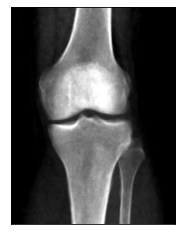

warped_image_A


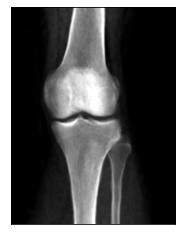

image_B


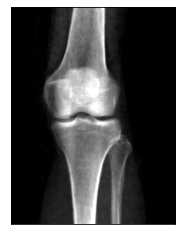

In [16]:
print("image to image registration on the test set")
print("image_A")
show(image_A[2, 0])
print("warped_image_A")
show(netGrad.warped_image_A[2, 0])
print("image_B")
show(image_B[2, 0])

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975]


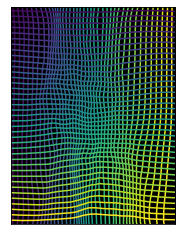

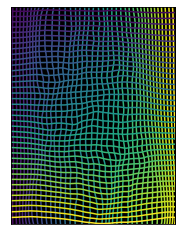

In [17]:
lines = np.arange(0, 1, 1/40)
print(lines)
N = 2
plt.contour(netGrad.phi_AB_vectorfield[N, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_AB_vectorfield[N, 0].detach().cpu(), lines)
show(image_A[0, 0] * 0)
plt.contour(netGrad.phi_BA_vectorfield[N, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_BA_vectorfield[N, 0].detach().cpu(), lines)
show(image_A[0, 0] * 0)

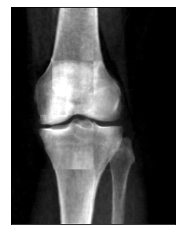

In [18]:
show(
    torch.tensor(
        itk.checker_board_image_filter(
            image_A[5, 0].cpu().numpy(), 
            netGrad.warped_image_B[5, 0].cpu().numpy()
        )
    )
)

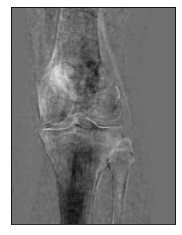

In [19]:
show((image_A[5, 0] - netGrad.warped_image_B[5, 0]))

In [15]:
netGrad.similarity = icon.ssd
netGrad.lmbda = .2

In [16]:
atlas = torch.nn.Parameter(torch.randn(1, 1, 845, 640, device="cuda"))
with torch.no_grad():
    atlas[:] = torch.mean(big_enough_knees, axis=0, keepdims=True)

atlas_exp = atlas.expand(BATCH_SIZE, -1, -1, -1).cuda()
params = [atlas]

In [17]:
optim = torch.optim.Adam(params, lr=.1)


In [18]:
for _ in range(1273):
    image_B = make_batch()
    optim.zero_grad()
    loss_obj = netGrad(atlas_exp, image_B)
    disp_direction_loss = torch.mean(torch.mean(netGrad.phi_AB_vectorfield - netGrad.identity_map, axis=0)**2)
    print(disp_direction_loss)
    (loss_obj.all_loss + 3 * disp_direction_loss).backward()
    optim.step()
    print(icon.losses.to_floats(loss_obj))

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.026200508698821068, inverse_consistency_loss=0.01105199009180069, similarity_loss=0.02399011142551899, transform_magnitude=0.0005368649144656956, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.028751075267791748, inverse_consistency_loss=0.021977651864290237, similarity_loss=0.02435554563999176, transform_magnitude=0.0013360229786485434, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.02429712563753128, inverse_consistency_loss=0.020699383690953255, similarity_loss=0.02015724778175354, transform_magnitude=0.0010292280931025743, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.0228385291993618, inverse_consistency_loss=0.016704373061656952, similarity_loss=0.01949765533208847, transform_magnitude=0.0006787597085349262, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLos

ICONLoss(all_loss=0.009203911758959293, inverse_consistency_loss=0.009459912776947021, similarity_loss=0.007311929017305374, transform_magnitude=0.001697314321063459, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01061187032610178, inverse_consistency_loss=0.009051352739334106, similarity_loss=0.008801599964499474, transform_magnitude=0.0012421254068613052, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012176455929875374, inverse_consistency_loss=0.008647294715046883, similarity_loss=0.010446997359395027, transform_magnitude=0.0008583044982515275, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010162930004298687, inverse_consistency_loss=0.00865296833217144, similarity_loss=0.008432336151599884, transform_magnitude=0.0009669479914009571, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01097886823117733, inverse_consistency_

ICONLoss(all_loss=0.010282780043780804, inverse_consistency_loss=0.009117776528000832, similarity_loss=0.008459224365651608, transform_magnitude=0.0016231723129749298, flips=0.0)
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01227402500808239, inverse_consistency_loss=0.01087124366313219, similarity_loss=0.010099776089191437, transform_magnitude=0.003464773064479232, flips=0.0)
tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012567463330924511, inverse_consistency_loss=0.010962331667542458, similarity_loss=0.010374996811151505, transform_magnitude=0.0034168746788054705, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01100447028875351, inverse_consistency_loss=0.009828146547079086, similarity_loss=0.009038841351866722, transform_magnitude=0.0010864785872399807, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011694525368511677, inverse_consistency_

ICONLoss(all_loss=0.011072895489633083, inverse_consistency_loss=0.008651511743664742, similarity_loss=0.009342593140900135, transform_magnitude=0.0014190063811838627, flips=0.0)
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008474151603877544, inverse_consistency_loss=0.008918163366615772, similarity_loss=0.00669051893055439, transform_magnitude=0.002194782951846719, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012075304053723812, inverse_consistency_loss=0.009172218851745129, similarity_loss=0.010240860283374786, transform_magnitude=0.0025210557505488396, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009992965497076511, inverse_consistency_loss=0.009249421767890453, similarity_loss=0.008143081329762936, transform_magnitude=0.0016705268062651157, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008487038314342499, inverse_consistenc

ICONLoss(all_loss=0.009544246830046177, inverse_consistency_loss=0.00938215758651495, similarity_loss=0.007667815312743187, transform_magnitude=0.000767625926528126, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010298404842615128, inverse_consistency_loss=0.010298974812030792, similarity_loss=0.008238609880208969, transform_magnitude=0.0010022558271884918, flips=0.0)
tensor(6.8582e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010290172882378101, inverse_consistency_loss=0.009291457943618298, similarity_loss=0.008431881666183472, transform_magnitude=0.0009585914667695761, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011625649407505989, inverse_consistency_loss=0.009295681491494179, similarity_loss=0.009766513481736183, transform_magnitude=0.0009800000116229057, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012045280076563358, inverse_consis

ICONLoss(all_loss=0.011061809957027435, inverse_consistency_loss=0.010089986026287079, similarity_loss=0.00904381275177002, transform_magnitude=0.0028737708926200867, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010069807060062885, inverse_consistency_loss=0.009109681472182274, similarity_loss=0.008247870951890945, transform_magnitude=0.0013756679836660624, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011074403300881386, inverse_consistency_loss=0.009037431329488754, similarity_loss=0.009266916662454605, transform_magnitude=0.00035892322193831205, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009691955521702766, inverse_consistency_loss=0.008681070059537888, similarity_loss=0.007955741137266159, transform_magnitude=0.001189862727187574, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010751407593488693, inverse_consisten

ICONLoss(all_loss=0.011543680913746357, inverse_consistency_loss=0.011329036206007004, similarity_loss=0.009277873672544956, transform_magnitude=0.0013587226858362556, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012449814938008785, inverse_consistency_loss=0.01038705836981535, similarity_loss=0.0103724030777812, transform_magnitude=0.0015032225055620074, flips=0.0)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010386663489043713, inverse_consistency_loss=0.010311758145689964, similarity_loss=0.008324312046170235, transform_magnitude=0.0022488583344966173, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010966538451611996, inverse_consistency_loss=0.01148039847612381, similarity_loss=0.008670458570122719, transform_magnitude=0.0017769311089068651, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012105118483304977, inverse_consistency_

ICONLoss(all_loss=0.011915941722691059, inverse_consistency_loss=0.012285035103559494, similarity_loss=0.009458934888243675, transform_magnitude=0.0016214610077440739, flips=0.0)
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00933278352022171, inverse_consistency_loss=0.009595870971679688, similarity_loss=0.007413608953356743, transform_magnitude=0.0017124895239248872, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009556875564157963, inverse_consistency_loss=0.009093496017158031, similarity_loss=0.007738176267594099, transform_magnitude=0.0014304830692708492, flips=0.0)
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.013559318147599697, inverse_consistency_loss=0.010877406224608421, similarity_loss=0.011383837088942528, transform_magnitude=0.003416159888729453, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010190373286604881, inverse_consistenc

ICONLoss(all_loss=0.014304718002676964, inverse_consistency_loss=0.009104473516345024, similarity_loss=0.012483823113143444, transform_magnitude=0.0007068016566336155, flips=0.0)
tensor(8.6268e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010476013645529747, inverse_consistency_loss=0.008855381049215794, similarity_loss=0.008704937063157558, transform_magnitude=0.0006319039384834468, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010807635262608528, inverse_consistency_loss=0.009248641319572926, similarity_loss=0.008957906626164913, transform_magnitude=0.000990578206256032, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011660000309348106, inverse_consistency_loss=0.012590101920068264, similarity_loss=0.009141979739069939, transform_magnitude=0.0014917528023943305, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009546168148517609, inverse_consi

ICONLoss(all_loss=0.01752602681517601, inverse_consistency_loss=0.01204388216137886, similarity_loss=0.015117250382900238, transform_magnitude=0.00218523689545691, flips=0.0)
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.015601187013089657, inverse_consistency_loss=0.01256262231618166, similarity_loss=0.013088662177324295, transform_magnitude=0.0016602159012109041, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.017407234758138657, inverse_consistency_loss=0.011333606205880642, similarity_loss=0.015140512958168983, transform_magnitude=0.0006546881631948054, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.013209719210863113, inverse_consistency_loss=0.009592713788151741, similarity_loss=0.011291176080703735, transform_magnitude=0.00035186996683478355, flips=0.0)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.014037412591278553, inverse_consistency_

ICONLoss(all_loss=0.012497765943408012, inverse_consistency_loss=0.01020083948969841, similarity_loss=0.0104575976729393, transform_magnitude=0.0006933274562470615, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01452199649065733, inverse_consistency_loss=0.009887230582535267, similarity_loss=0.012544550001621246, transform_magnitude=0.0009312615729868412, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010616413317620754, inverse_consistency_loss=0.009375043213367462, similarity_loss=0.008741404861211777, transform_magnitude=0.0017672667745500803, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011290756985545158, inverse_consistency_loss=0.009308040142059326, similarity_loss=0.009429149329662323, transform_magnitude=0.0016398112056776881, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010510636493563652, inverse_consistency_

ICONLoss(all_loss=0.01210151705890894, inverse_consistency_loss=0.008751981891691685, similarity_loss=0.010351120494306087, transform_magnitude=0.0014054053463041782, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01117985974997282, inverse_consistency_loss=0.008616257458925247, similarity_loss=0.009456608444452286, transform_magnitude=0.0011627263156697154, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01226020883768797, inverse_consistency_loss=0.009327691979706287, similarity_loss=0.010394670069217682, transform_magnitude=0.0011210994562134147, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010719642974436283, inverse_consistency_loss=0.009433582425117493, similarity_loss=0.008832926861941814, transform_magnitude=0.002199946902692318, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01179877482354641, inverse_consistency_l

ICONLoss(all_loss=0.010378874838352203, inverse_consistency_loss=0.009912455454468727, similarity_loss=0.008396383374929428, transform_magnitude=0.0015825474401935935, flips=0.0)
tensor(8.8563e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012283535674214363, inverse_consistency_loss=0.010442078113555908, similarity_loss=0.010195120237767696, transform_magnitude=0.00045772470184601843, flips=0.0)
tensor(6.7957e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008647575974464417, inverse_consistency_loss=0.008333977311849594, similarity_loss=0.006980780512094498, transform_magnitude=0.0005801816005259752, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010576351545751095, inverse_consistency_loss=0.0094729233533144, similarity_loss=0.0086817666888237, transform_magnitude=0.0007927832775749266, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009778205305337906, inverse_con

ICONLoss(all_loss=0.009438207373023033, inverse_consistency_loss=0.008333135396242142, similarity_loss=0.00777158048003912, transform_magnitude=0.0007226810557767749, flips=0.0)
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010564523749053478, inverse_consistency_loss=0.009877750650048256, similarity_loss=0.008588973432779312, transform_magnitude=0.0022634274791926146, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009719698689877987, inverse_consistency_loss=0.00873887725174427, similarity_loss=0.007971922867000103, transform_magnitude=0.0010758902644738555, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012444502674043179, inverse_consistency_loss=0.0103601710870862, similarity_loss=0.010372468270361423, transform_magnitude=0.0014728185487911105, flips=0.0)
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010396020486950874, inverse_consistency_

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008787225000560284, inverse_consistency_loss=0.008234957233071327, similarity_loss=0.007140233647078276, transform_magnitude=0.0009384694858454168, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012521947734057903, inverse_consistency_loss=0.011164677329361439, similarity_loss=0.01028901245445013, transform_magnitude=0.004198319744318724, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008525081910192966, inverse_consistency_loss=0.009446043521165848, similarity_loss=0.006635873578488827, transform_magnitude=0.0015290983719751239, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010127099230885506, inverse_consistency_loss=0.009219765663146973, similarity_loss=0.008283145725727081, transform_magnitude=0.0010690034832805395, flips=0.0)
tensor(8.7277e-05, device='cuda:0', grad_fn=<MeanBackward0

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008643127977848053, inverse_consistency_loss=0.008341602981090546, similarity_loss=0.006974807009100914, transform_magnitude=0.001016206806525588, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010469099506735802, inverse_consistency_loss=0.008491192013025284, similarity_loss=0.008770860731601715, transform_magnitude=0.000992165761999786, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010466260835528374, inverse_consistency_loss=0.009875353425741196, similarity_loss=0.008491190150380135, transform_magnitude=0.0025813947431743145, flips=0.0)
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01165009569376707, inverse_consistency_loss=0.011112043634057045, similarity_loss=0.009427687153220177, transform_magnitude=0.0037427321076393127, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
IC

ICONLoss(all_loss=0.011699310503900051, inverse_consistency_loss=0.009254148229956627, similarity_loss=0.00984848104417324, transform_magnitude=0.0008603267488069832, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010102144442498684, inverse_consistency_loss=0.008824780583381653, similarity_loss=0.008337188512086868, transform_magnitude=0.0015598080353811383, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009994753636419773, inverse_consistency_loss=0.009273297153413296, similarity_loss=0.008140094578266144, transform_magnitude=0.0016656096559017897, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009483424946665764, inverse_consistency_loss=0.010347362607717514, similarity_loss=0.007413952611386776, transform_magnitude=0.002431314205750823, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01106332242488861, inverse_consistency

ICONLoss(all_loss=0.012849641963839531, inverse_consistency_loss=0.008760496973991394, similarity_loss=0.011097542941570282, transform_magnitude=0.0005527089815586805, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01050693728029728, inverse_consistency_loss=0.009026944637298584, similarity_loss=0.008701547980308533, transform_magnitude=0.0006570220575667918, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012020215392112732, inverse_consistency_loss=0.008697330951690674, similarity_loss=0.010280748829245567, transform_magnitude=0.001339812413789332, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011653370223939419, inverse_consistency_loss=0.00937142875045538, similarity_loss=0.009779084473848343, transform_magnitude=0.0009696087799966335, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012233063578605652, inverse_consistency

ICONLoss(all_loss=0.010382016189396381, inverse_consistency_loss=0.010455254465341568, similarity_loss=0.008290965110063553, transform_magnitude=0.0012294654734432697, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011777267791330814, inverse_consistency_loss=0.009959529154002666, similarity_loss=0.009785361588001251, transform_magnitude=0.0012877914123237133, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011159168556332588, inverse_consistency_loss=0.010472754016518593, similarity_loss=0.009064617566764355, transform_magnitude=0.0011672499822452664, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012119701132178307, inverse_consistency_loss=0.010938959196209908, similarity_loss=0.009931908920407295, transform_magnitude=0.0020232691895216703, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01076241210103035, inverse_consisten

ICONLoss(all_loss=0.009594621136784554, inverse_consistency_loss=0.00827113352715969, similarity_loss=0.007940394803881645, transform_magnitude=0.0015962698962539434, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01056083757430315, inverse_consistency_loss=0.008558178320527077, similarity_loss=0.00884920172393322, transform_magnitude=0.001092541846446693, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009864242747426033, inverse_consistency_loss=0.009758202359080315, similarity_loss=0.00791260227560997, transform_magnitude=0.0024964057374745607, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010445849969983101, inverse_consistency_loss=0.010763818398118019, similarity_loss=0.008293086662888527, transform_magnitude=0.0013815880520269275, flips=0.0)
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008666547946631908, inverse_consistency_l

ICONLoss(all_loss=0.01047358475625515, inverse_consistency_loss=0.00890113040804863, similarity_loss=0.008693358860909939, transform_magnitude=0.0010996442288160324, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009877304546535015, inverse_consistency_loss=0.009005789645016193, similarity_loss=0.008076146245002747, transform_magnitude=0.0015590791590511799, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009508493356406689, inverse_consistency_loss=0.008937128819525242, similarity_loss=0.007721067406237125, transform_magnitude=0.0008124068845063448, flips=0.0)
tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009982272051274776, inverse_consistency_loss=0.009825647808611393, similarity_loss=0.008017142303287983, transform_magnitude=0.002482315059751272, flips=0.0)
tensor(9.3518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010670785792171955, inverse_consist

ICONLoss(all_loss=0.01095130667090416, inverse_consistency_loss=0.009777136147022247, similarity_loss=0.00899587944149971, transform_magnitude=0.0015454738168045878, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010826519690454006, inverse_consistency_loss=0.009511150419712067, similarity_loss=0.008924289606511593, transform_magnitude=0.0006639978964813054, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011680997908115387, inverse_consistency_loss=0.010608379729092121, similarity_loss=0.009559322148561478, transform_magnitude=0.0022619697265326977, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011421236209571362, inverse_consistency_loss=0.009165365248918533, similarity_loss=0.00958816334605217, transform_magnitude=0.0017342492938041687, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012535138055682182, inverse_consistency

ICONLoss(all_loss=0.010025144554674625, inverse_consistency_loss=0.009309764951467514, similarity_loss=0.008163191378116608, transform_magnitude=0.0009652881417423487, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009591909125447273, inverse_consistency_loss=0.00962507352232933, similarity_loss=0.007666894234716892, transform_magnitude=0.001263858168385923, flips=0.0)
tensor(3.7355e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008881733752787113, inverse_consistency_loss=0.009146813303232193, similarity_loss=0.0070523712784051895, transform_magnitude=0.0009850126225501299, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010334345512092113, inverse_consistency_loss=0.008894183672964573, similarity_loss=0.008555509150028229, transform_magnitude=0.0012622337089851499, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010528870858252048, inverse_consi

ICONLoss(all_loss=0.009497741237282753, inverse_consistency_loss=0.009010675363242626, similarity_loss=0.007695605978369713, transform_magnitude=0.0019449274986982346, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008337704464793205, inverse_consistency_loss=0.008264787495136261, similarity_loss=0.006684746593236923, transform_magnitude=0.0010293578961864114, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008836272172629833, inverse_consistency_loss=0.009286746382713318, similarity_loss=0.006978922989219427, transform_magnitude=0.002325542736798525, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01095647644251585, inverse_consistency_loss=0.009449750185012817, similarity_loss=0.009066526778042316, transform_magnitude=0.001053106738254428, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009669376537203789, inverse_consistency

ICONLoss(all_loss=0.01105022057890892, inverse_consistency_loss=0.008844872936606407, similarity_loss=0.009281245991587639, transform_magnitude=0.0004382593324407935, flips=0.0)
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009720273315906525, inverse_consistency_loss=0.010326897725462914, similarity_loss=0.007654894143342972, transform_magnitude=0.0020900219678878784, flips=0.0)
tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009545356966555119, inverse_consistency_loss=0.010144948959350586, similarity_loss=0.007516367360949516, transform_magnitude=0.002826170064508915, flips=0.0)
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009916810318827629, inverse_consistency_loss=0.009039373137056828, similarity_loss=0.008108935318887234, transform_magnitude=0.0013791611418128014, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010371203534305096, inverse_consistenc

ICONLoss(all_loss=0.01129450835287571, inverse_consistency_loss=0.009931243024766445, similarity_loss=0.009308259934186935, transform_magnitude=0.0005962392315268517, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009655782021582127, inverse_consistency_loss=0.00825352594256401, similarity_loss=0.00800507701933384, transform_magnitude=0.0013828742085024714, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012621190398931503, inverse_consistency_loss=0.0097081633284688, similarity_loss=0.010679557919502258, transform_magnitude=0.0012354940408840775, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01064517442137003, inverse_consistency_loss=0.008667286485433578, similarity_loss=0.008911716751754284, transform_magnitude=0.0013014221331104636, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010731598362326622, inverse_consistency_lo

ICONLoss(all_loss=0.009675444103777409, inverse_consistency_loss=0.010277194902300835, similarity_loss=0.007620004937052727, transform_magnitude=0.002096050651744008, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012225352227687836, inverse_consistency_loss=0.009714493528008461, similarity_loss=0.010282453149557114, transform_magnitude=0.0020323325879871845, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.0132233165204525, inverse_consistency_loss=0.010128499008715153, similarity_loss=0.011197616346180439, transform_magnitude=0.001999560045078397, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01008764747530222, inverse_consistency_loss=0.009280088357627392, similarity_loss=0.008231629617512226, transform_magnitude=0.0009807816240936518, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010841546580195427, inverse_consistency_l

ICONLoss(all_loss=0.009315386414527893, inverse_consistency_loss=0.008797160349786282, similarity_loss=0.007555954623967409, transform_magnitude=0.0010889755794778466, flips=0.0)
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009073304943740368, inverse_consistency_loss=0.009213143959641457, similarity_loss=0.007230675779283047, transform_magnitude=0.0022343231830745935, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010503566823899746, inverse_consistency_loss=0.008947128430008888, similarity_loss=0.008714141324162483, transform_magnitude=0.0012194012524560094, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010206085629761219, inverse_consistency_loss=0.00904875248670578, similarity_loss=0.008396334946155548, transform_magnitude=0.001239580917172134, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009968232363462448, inverse_consistenc

ICONLoss(all_loss=0.011694183573126793, inverse_consistency_loss=0.008847972378134727, similarity_loss=0.009924588724970818, transform_magnitude=0.000542198249604553, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009127226658165455, inverse_consistency_loss=0.008561844006180763, similarity_loss=0.007414857856929302, transform_magnitude=0.001125315553508699, flips=0.0)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010856132954359055, inverse_consistency_loss=0.009535356424748898, similarity_loss=0.00894906185567379, transform_magnitude=0.0018970936071127653, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01129759382456541, inverse_consistency_loss=0.009706294164061546, similarity_loss=0.009356334805488586, transform_magnitude=0.0013526113471016288, flips=0.0)
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.0103174839168787, inverse_consistency_lo

ICONLoss(all_loss=0.014226334169507027, inverse_consistency_loss=0.012527547776699066, similarity_loss=0.011720824986696243, transform_magnitude=0.002398047363385558, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01331007294356823, inverse_consistency_loss=0.011998714879155159, similarity_loss=0.010910329408943653, transform_magnitude=0.0015144302742555737, flips=0.0)
tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.014251597225666046, inverse_consistency_loss=0.01247313804924488, similarity_loss=0.01175696961581707, transform_magnitude=0.0018535916460677981, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012327244505286217, inverse_consistency_loss=0.01138284057378769, similarity_loss=0.010050676763057709, transform_magnitude=0.002001781016588211, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.013017783872783184, inverse_consistency_lo

ICONLoss(all_loss=0.009901165962219238, inverse_consistency_loss=0.00965767540037632, similarity_loss=0.007969630882143974, transform_magnitude=0.0014625592157244682, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010187855921685696, inverse_consistency_loss=0.009947013109922409, similarity_loss=0.008198453113436699, transform_magnitude=0.0013140025548636913, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012961335480213165, inverse_consistency_loss=0.010053852573037148, similarity_loss=0.010950565338134766, transform_magnitude=0.0012506261700764298, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010395947843790054, inverse_consistency_loss=0.009628541767597198, similarity_loss=0.008470239117741585, transform_magnitude=0.0009732645121403039, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009122544899582863, inverse_consisten

ICONLoss(all_loss=0.010827431455254555, inverse_consistency_loss=0.010213524103164673, similarity_loss=0.00878472626209259, transform_magnitude=0.0015516929561272264, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010055848397314548, inverse_consistency_loss=0.009900588542222977, similarity_loss=0.008075730875134468, transform_magnitude=0.002006098162382841, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010269113816320896, inverse_consistency_loss=0.008815735578536987, similarity_loss=0.008505966514348984, transform_magnitude=0.0012302426621317863, flips=0.0)


KeyboardInterrupt: 

In [19]:
image_B = test_imgs.cuda()
with torch.no_grad():
    netGrad(atlas.expand(10, -1, -1, -1).cuda(), image_B)

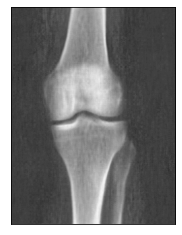

In [22]:
show(atlas[0, 0])


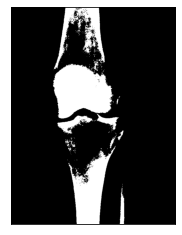

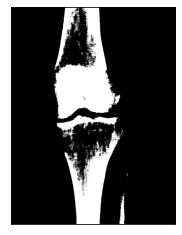

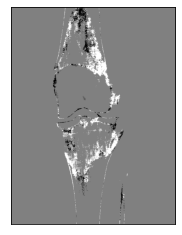

In [23]:
show(image_B[0, 0] > .5)
show(netGrad.warped_image_A[0, 0]> .5)
show((netGrad.warped_image_A[0, 0] > .5)* 1. - (image_B[0, 0] > .5) * 1.)

image


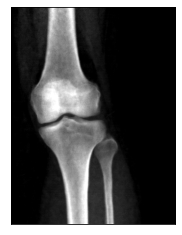

warped_atlas


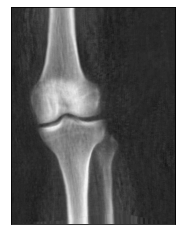

difference image


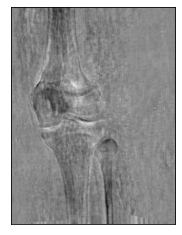

In [106]:
image_B = make_batch()
with torch.no_grad():
    netGrad(atlas.expand(4, -1, -1, -1).cuda(), image_B)
print("image")
show(image_B[0, 0])
print("warped_atlas")
show(netGrad.warped_image_A[0, 0])
print("difference image")
show((netGrad.warped_image_A[0, 0]) - (image_B[0, 0]))

In [174]:
len(big_enough_knees)

123

image


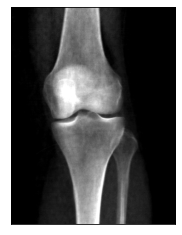

warped_atlas


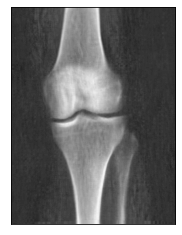

difference image


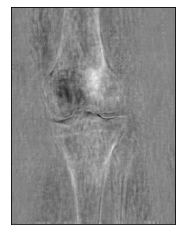

warped_image


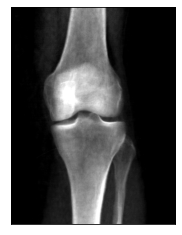

image


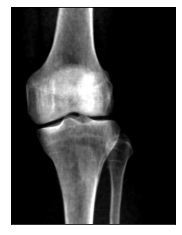

warped_atlas


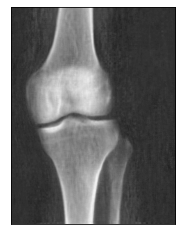

difference image


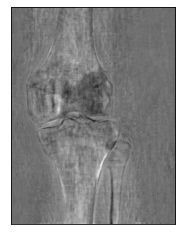

warped_image


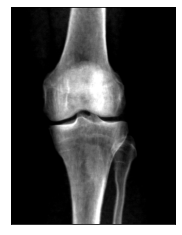

image


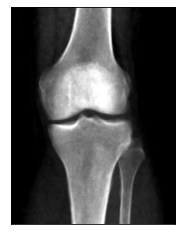

warped_atlas


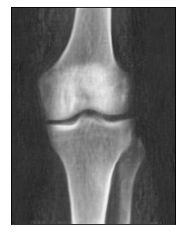

difference image


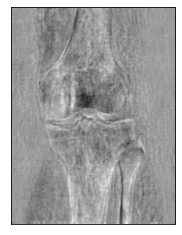

warped_image


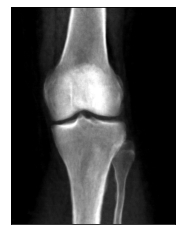

image


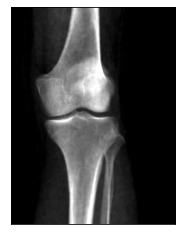

warped_atlas


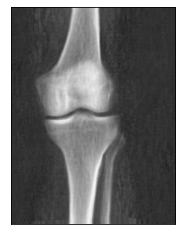

difference image


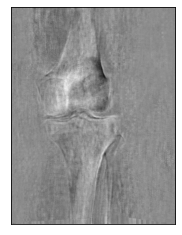

warped_image


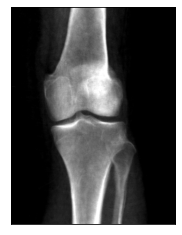

image


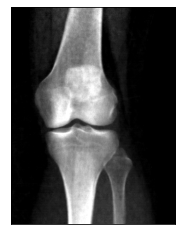

warped_atlas


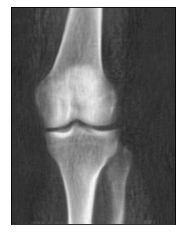

difference image


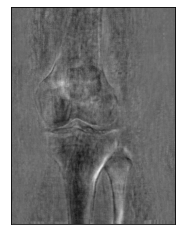

warped_image


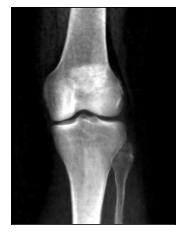

image


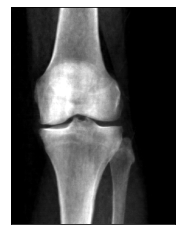

warped_atlas


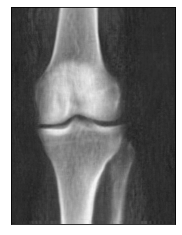

difference image


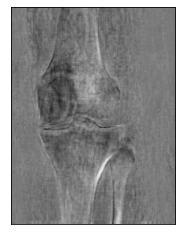

warped_image


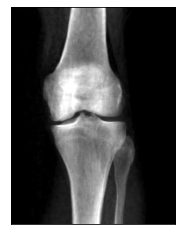

image


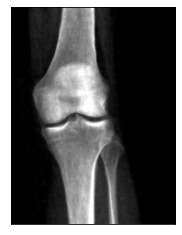

warped_atlas


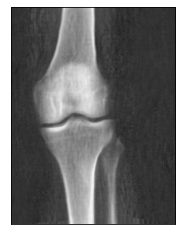

difference image


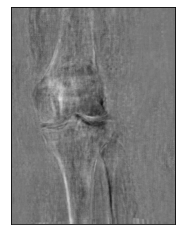

warped_image


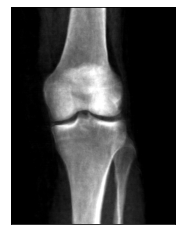

image


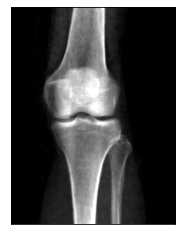

warped_atlas


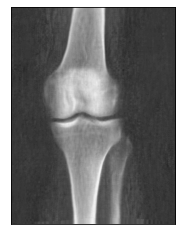

difference image


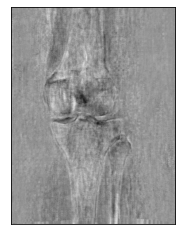

warped_image


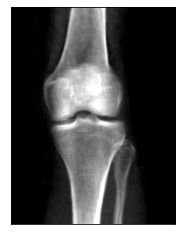

image


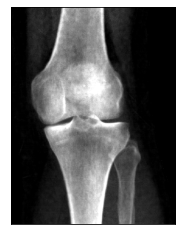

warped_atlas


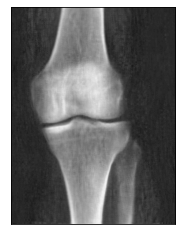

difference image


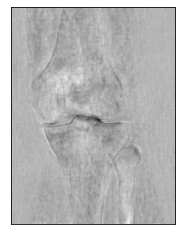

warped_image


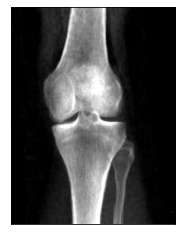

image


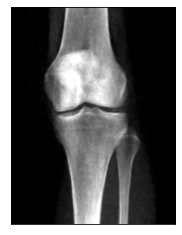

warped_atlas


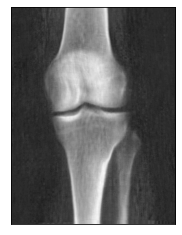

difference image


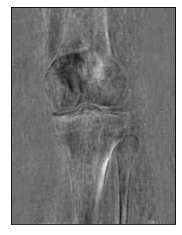

warped_image


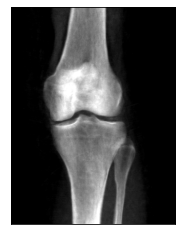

In [25]:
for N in range(10):
    print("image")
    show(image_B[N, 0])
    print("warped_atlas")
    show(netGrad.warped_image_A[N, 0])
    print("difference image")
    show((netGrad.warped_image_A[N, 0]) - (image_B[N, 0]))
    print("warped_image")
    show(netGrad.warped_image_B[N, 0])

warped_image


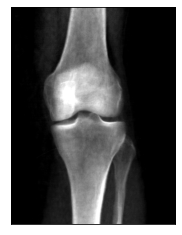

warped_image


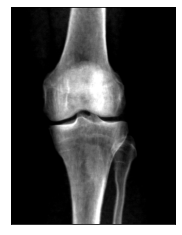

warped_image


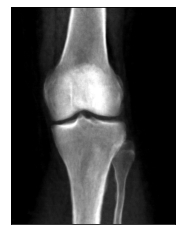

warped_image


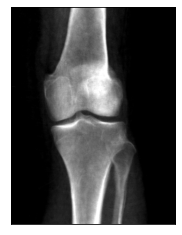

warped_image


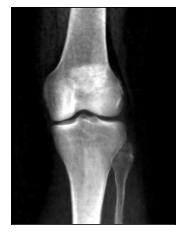

warped_image


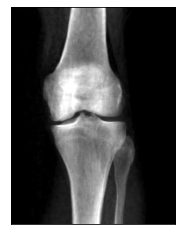

warped_image


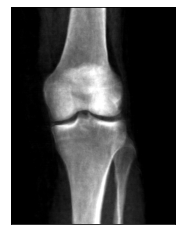

warped_image


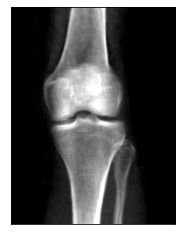

warped_image


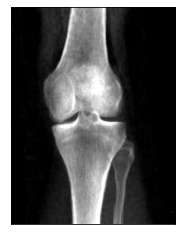

warped_image


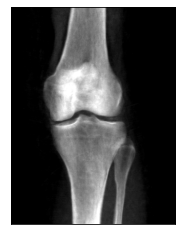

In [26]:
for N in range(10):

    print("warped_image")
    show(netGrad.warped_image_B[N, 0])

In [ ]:
dxa atlas + different image + different image warped to dxa atlas with grid + zoom in on cartilage

image


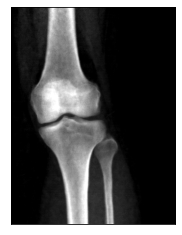

atlas


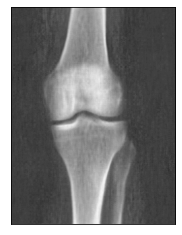

warped_image


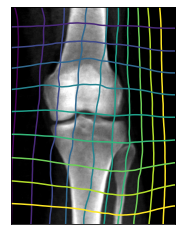

image detail


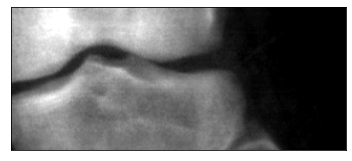

atlas detail


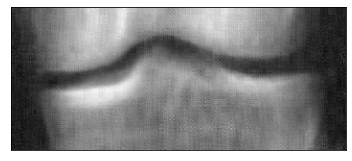

warped image detail


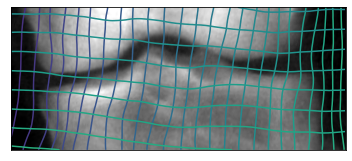

before


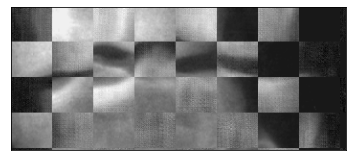

after


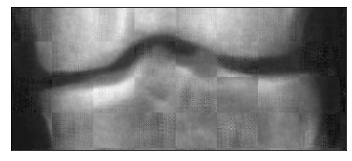

warped image overlaid with jacobian


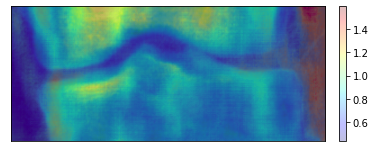

In [135]:
lines = np.arange(0, 1, .1)
N = 0
print("image")
show(image_B[N, 0])
print("atlas")

show(atlas[0, 0])
print("warped_image")
plt.contour(netGrad.phi_BA_vectorfield[N, 1].detach().cpu(), lines)
plt.contour(netGrad.phi_BA_vectorfield[N, 0].detach().cpu(), lines)
show(netGrad.warped_image_B[N, 0])

print("image detail")
i4 = image_B[N, 0, 375:525, 125:475]
show(i4)

print("atlas detail")
i1 = atlas[0, 0, 375:525, 125:475]
show(i1)
print("warped image detail")
lines = np.arange(0, 1, .02)

i2 = netGrad.warped_image_B[N, 0, 375:525, 125:475]
plt.contour(netGrad.phi_BA_vectorfield[N, 1, 375:525, 125:475].detach().cpu(), lines)
plt.contour(netGrad.phi_BA_vectorfield[N, 0, 375:525, 125:475].detach().cpu(), lines)
show(i2)
print("before")
show(torch.tensor(itk.checker_board_image_filter(i1.detach().cpu().numpy(), i4.detach().cpu().numpy(), checker_pattern=(8, 4))))

print("after")
show(torch.tensor(itk.checker_board_image_filter(i1.detach().cpu().numpy(), i2.detach().cpu().numpy(), checker_pattern=(8, 4))))


print("warped image overlaid with jacobian")
plt.imshow(i2.cpu().detach())
plt.imshow(dA[0, 375:525, 125:475], alpha=.25, cmap="jet")
plt.xticks([])
plt.yticks([])
im_ratio = i2.shape[0]/i2.shape[1]
plt.colorbar(fraction=0.047*im_ratio, pad=0.04)
plt.show()

before


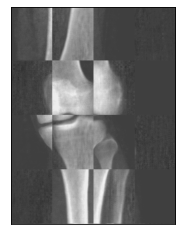

before


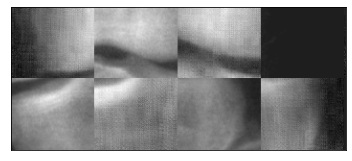

after


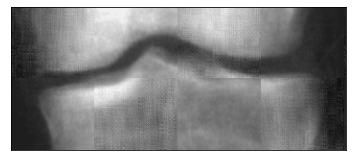

In [138]:
print("before")
show(torch.tensor(itk.checker_board_image_filter(image_B[0, 0].detach().cpu().numpy(), atlas[0, 0].detach().cpu().numpy(), checker_pattern=(4, 4))))

print("before")
show(torch.tensor(itk.checker_board_image_filter(i1.detach().cpu().numpy(), i4.detach().cpu().numpy(), checker_pattern=(4, 2))))

print("after")
show(torch.tensor(
    itk.checker_board_image_filter(i1.detach().cpu().numpy(), 
                                   i2.detach().cpu().numpy(), checker_pattern=(4, 2))))

In [119]:
phi = netGrad.phi_BA_vectorfield
du = (phi[:, :, 1:, :-1] - phi[:, :, :-1, :-1]).detach().cpu()
dv = (phi[:, :, :-1, 1:] - phi[:, :, :-1, :-1]).detach().cpu()
dA = du[:, 0] * dv[:, 1] - du[:, 1] * dv[:, 0]
dA /= 1.85e-6

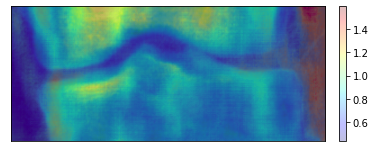

In [134]:
plt.imshow(i2.cpu().detach())
plt.imshow(dA[0, 375:525, 125:475], alpha=.25, cmap="jet")
plt.xticks([])
plt.yticks([])
im_ratio = i2.shape[0]/i2.shape[1]
plt.colorbar(fraction=0.047*im_ratio, pad=0.04)
plt.show()

In [139]:
torch.save(atlas, "atlas1")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
